In [1]:
import cv2 as cv
from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip, ImageSequenceClip
import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf

from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

import tensorflow_hub as hub

In [2]:
!nvidia-smi

Wed Apr 28 13:10:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb#scrollTo=D9IwDpOtpIHW
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
    draw.text((left + margin, text_bottom - text_height - margin), display_str, fill="black", font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf", 25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

In [3]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]
detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
def run_detector(detector, image):
  converted_img  = tf.image.convert_image_dtype(image, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()
  print(result.keys())
  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(image, result["detection_boxes"], result["detection_class_entities"], result["detection_scores"])
  return image_with_boxes

dict_keys(['detection_class_labels', 'detection_class_entities', 'detection_class_names', 'detection_boxes', 'detection_scores'])
Found 100 objects.
Inference time:  12.4549560546875


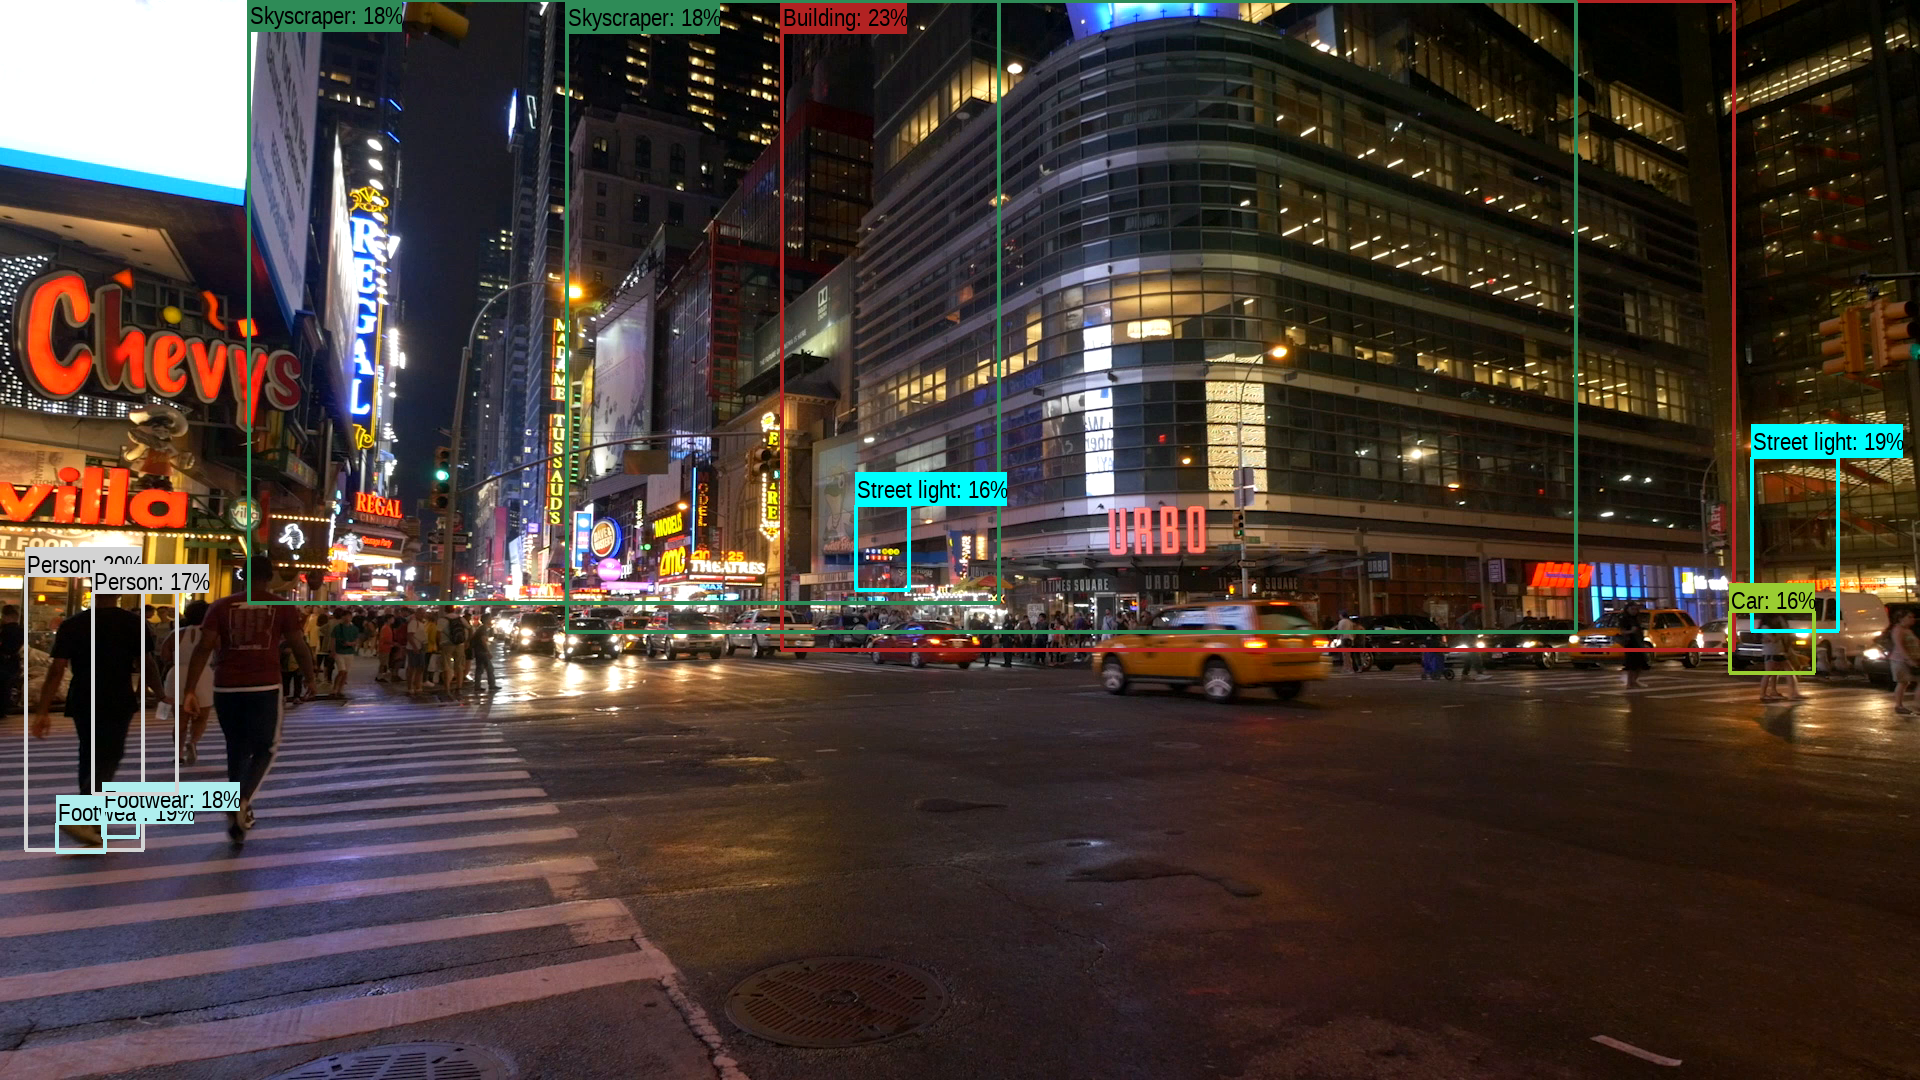

In [5]:
# https://www.videvo.net/video/busy-times-square-at-night/5284/
clip = VideoFileClip('video.mp4') 
for frame in clip.iter_frames():
    detected = run_detector(detector, frame)
    cv2_imshow(cv.cvtColor(detected, cv.COLOR_BGR2RGB))
    break

In [ ]:
clip = VideoFileClip('video.mp4') 
detected = []
for frame in clip.iter_frames():
    detected.append(run_detector(detector, frame))

detected_clip = ImageSequenceClip(detected, fps=clip.fps)
detected_clip.write_videofile('detected_clip.mp4')